In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, Conv2D, MaxPooling2D

In [2]:
# connecting to gdrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = f"/content/gdrive/MyDrive/stat_ml"

Mounted at /content/gdrive


In [3]:
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()
print(f'Training data shape:\t{train_X.shape}\t{train_Y.shape}')
print(f'Testing data shape:\t{test_X.shape}\t{test_Y.shape}')

Training data shape:	(60000, 28, 28)	(60000,)
Testing data shape:	(10000, 28, 28)	(10000,)


Train set contains 60000 images of 28x28 pixel brightness values

Test set contains 10000 images of 28x28 pixel brightness values

In [4]:
classes = np.unique(train_Y)
nClasses = len(classes)
print(f'Total number of unique outputs:\t{nClasses}')
print(f'Output classes:\t{classes}')

Total number of unique outputs:	10
Output classes:	[0 1 2 3 4 5 6 7 8 9]


The fashion_mnist dataset has 10 classes labeled by integers ranging from 0 to 9

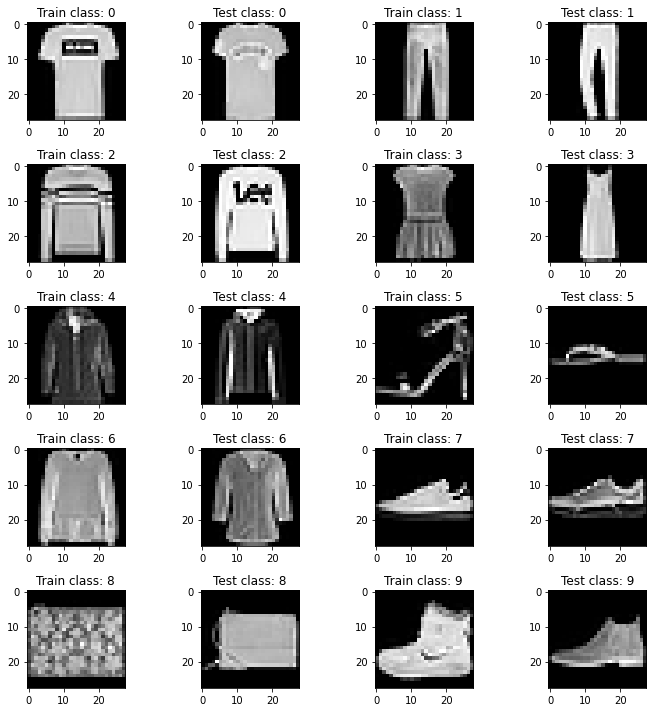

In [5]:
# initialize dictionaries to keep track of each class's first occurrence
train_ind, test_ind = {}, {}
# iterate through the train labels array and store first occurrence of each class
for i, val in enumerate(train_Y):
    if val not in train_ind:
        train_ind[val] = i
for i, val in enumerate(test_Y):
    if val not in test_ind:
        test_ind[val] = i

# forming train and test arrays of indexes sorted by class labels  
train_demo_ind = list(dict(sorted(train_ind.items())).values())
test_demo_ind = list(dict(sorted(test_ind.items())).values())

plt.figure(figsize=(10, 10))

for i in range(nClasses):
    # display the i-th class image in training data in grayscale
    train_ind = train_demo_ind[i]
    plt.subplot(5, 4, 2*i+1)
    plt.imshow(train_X[train_ind,:,:], cmap='gray')
    plt.title(f"Train class: {train_Y[train_ind]}")
    
    # display the i-th class image in testing data in grayscale
    test_ind = test_demo_ind[i]
    plt.subplot(5, 4, 2*i+2)
    plt.imshow(test_X[test_ind,:,:], cmap='gray')
    plt.title(f"Test class: {test_Y[test_ind]}")
    
plt.tight_layout()
plt.show()

The figure above demonstrates grayscale image examples of all 10 classes in both train and test datasets. 

The classes include 3 shoes types, 1 dress, 1 accessory, 1 trousers, and 4 outwear types. 

In [6]:
# get frequencies of all class labels in the train and test datasets 
train_freq_dict, test_freq_dict = Counter(train_Y), Counter(test_Y)

# print frequencies of integers
for label in classes:
    print(f"{label}:\t train - {train_freq_dict[label]}\t test - {test_freq_dict[label]}")

0:	 train - 6000	 test - 1000
1:	 train - 6000	 test - 1000
2:	 train - 6000	 test - 1000
3:	 train - 6000	 test - 1000
4:	 train - 6000	 test - 1000
5:	 train - 6000	 test - 1000
6:	 train - 6000	 test - 1000
7:	 train - 6000	 test - 1000
8:	 train - 6000	 test - 1000
9:	 train - 6000	 test - 1000


The data is well-balanced since all classes are equally distributed in both train and test sets.

In [7]:
# extending dimensionality of train and test dataset samples
train_X, test_X = train_X.reshape(-1, 28,28, 1), test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Train and test datasets containing matrix representations of images have been augmented with an extra dimension. 

In [8]:
print(f"Original pixel values:\t max {train_X.max()}\t min {train_X.min()}")

# changing the type of image representations in both train and test datasets 
# from discrete integers to continuous float numbers of the pixel values
train_X, test_X = train_X.astype('float32'), test_X.astype('float32')
# normalizing pixel values to the range from 0 to 1
train_X, test_X = train_X / 255., test_X / 255.

print(f"Scaled pixel values:\t max {train_X.max()}\t min {train_X.min()}")

Original pixel values:	 max 255	 min 0
Scaled pixel values:	 max 1.0	 min 0.0


In [9]:
# changing the labels from categorical to one-hot encoding
train_Y_one_hot, test_Y_one_hot = to_categorical(train_Y), to_categorical(test_Y)

# display the change for category label using one-hot encoding
print(f'Original class label:\t{train_Y[0]}')
print(f'Converted to one-hot vector:\t{train_Y_one_hot[0]}')

Original class label:	9
Converted to one-hot vector:	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Each class label assigned the unique integer index which was encoded to a binary vector of length 10 where all values are zero except for the index of the corresponding value set to one.

In [10]:
# splitting the train data to train (80%) and valid (20%) subsets of 
# the scaled X inputs and the encoded label outputs 
train_X, valid_X, train_label, valid_label = train_test_split(train_X, 
                                                              train_Y_one_hot, 
                                                              test_size=0.2, 
                                                              random_state=1337)
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

Training subsets contain 48000 samples of image matrix views and their encoded class labels

Validation subsets contain 12000 samples of image matrix views and their encoded class labels

In [11]:
# defining common dataloader batch size and number of training epochs
batch_size = 64
epochs = 20

In [12]:
# defining model architecture

# Define a Sequential model for fashion classification
fashion_model = Sequential()
# Add a convolutional layer with 32 filters of size 3x3 and linear activation 
# function, set input shape to (28,28,1) and padding to 'same'
fashion_model.add(Conv2D(32, kernel_size=(3,3), activation='linear',
                         input_shape=(28,28,1), padding='same'))
# Add a leaky ReLU activation function with alpha=0.1
fashion_model.add(LeakyReLU(alpha=0.1))
# Add a max pooling layer with pool size 2x2 and padding 'same'
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
# Add another convolutional layer with 64 filters of size 3x3 and linear 
# activation function, set padding to 'same'
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
# Add another leaky ReLU activation function with alpha=0.1
fashion_model.add(LeakyReLU(alpha=0.1))
# Add another max pooling layer with pool size 2x2 and padding 'same'
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add another convolutional layer with 128 filters of size 3x3 and linear 
# activation function, set padding to 'same'
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# Add another leaky ReLU activation function with alpha=0.1
fashion_model.add(LeakyReLU(alpha=0.1))
# Add another max pooling layer with pool size 2x2 and padding 'same'
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Flatten the output of the previous layer
fashion_model.add(Flatten())
# Add a fully connected layer with 128 units and linear activation function
fashion_model.add(Dense(128, activation='linear'))
# Add another leaky ReLU activation function with alpha=0.1
fashion_model.add(LeakyReLU(alpha=0.1))
# Add a fully connected layer with 10 units and softmax activation function
fashion_model.add(Dense(nClasses, activation='softmax'))

fashion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

The model has 13 layers in total, the input shape set to (28,28,1) image size, the output shape set to (10,) one-hot class labels encoding. 

In [13]:
# compiling the fashion model with categorical crossentropy as the loss function,
# Adam optimizer as the optimizer, and accuracy as the metric to be evaluated
fashion_model.compile(loss=keras.losses.categorical_crossentropy, 
                      optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [14]:
# training the defined model to fit the training data which loaded in batches of
# size 64 during 20 epochs each finishing with the model accuracy evaluation on 
# the validation dataset, while loss is calculated by taking the negative log
# of the predicted probability of the true class label
fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,
                                  epochs=epochs, verbose=1,
                                  validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 122s 162ms/step - loss: 0.4541 - accuracy: 0.8352 - val_loss: 0.3603 - val_accuracy: 0.8739
Epoch 2/20
750/750 [==============================] - 137s 183ms/step - loss: 0.2882 - accuracy: 0.8956 - val_loss: 0.2663 - val_accuracy: 0.9014
Epoch 3/20
750/750 [==============================] - 131s 175ms/step - loss: 0.2403 - accuracy: 0.9116 - val_loss: 0.2468 - val_accuracy: 0.9103
Epoch 4/20
750/750 [==============================] - 113s 150ms/step - loss: 0.2071 - accuracy: 0.9230 - val_loss: 0.2449 - val_accuracy: 0.9085
Epoch 5/20
750/750 [==============================] - 131s 175ms/step - loss: 0.1806 - accuracy: 0.9326 - val_loss: 0.2416 - val_accuracy: 0.9133
Epoch 6/20
750/750 [==============================] - 117s 155ms/step - loss: 0.1592 - accuracy: 0.9408 - val_loss: 0.2268 - val_accuracy: 0.9166
Epoch 7/20
750/750 [==============================] - 151s 201ms/step - loss: 0.1395 - accuracy: 0.9480 - val_loss: 0.2319 -

In [15]:
# evaluating the model on the previously unseen test dataset
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)
print(f'Test loss:\t{test_eval[0]}')
print(f'Test accuracy:\t{round(test_eval[1] * 100, 2)}%')

Test loss:	0.49639731645584106
Test accuracy:	91.12%


The accuracy is higher than 90% which is good enough, but the loss is too high. 

In [16]:
# common function to draw accuracy and loss graphs of the models training metrics 
def model_metric(epochs, model_train):
  # getting training and validation accuracy and loss of the trained model
  accuracy = model_train.history['accuracy']
  val_accuracy = model_train.history['val_accuracy']
  loss = model_train.history['loss']
  val_loss = model_train.history['val_loss']

  # drawing graph lines of the recorded model performance metrics
  plt.figure(figsize=(12, 6))
  epochs_range = range(epochs)
  plt.plot(epochs_range, accuracy, 'bo', label='Training')
  plt.plot(epochs_range, val_accuracy, 'r', label='Validation')
  plt.title('Accuracy')
  plt.legend()

  plt.figure(figsize=(12, 6))
  plt.plot(epochs_range, loss, 'bo', label='Training')
  plt.plot(epochs_range, val_loss, 'r', label='Validation')
  plt.title('Loss')
  plt.legend()

  plt.show()

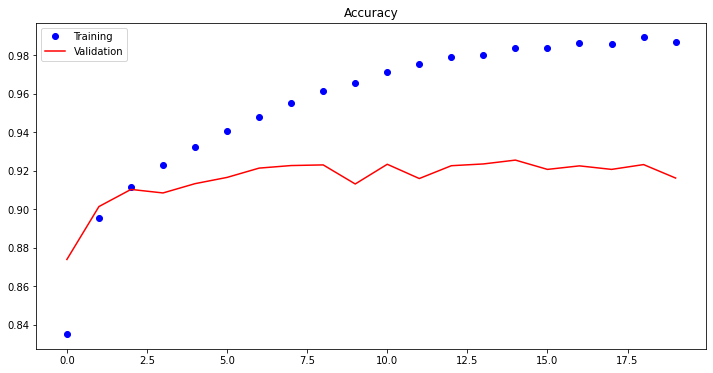

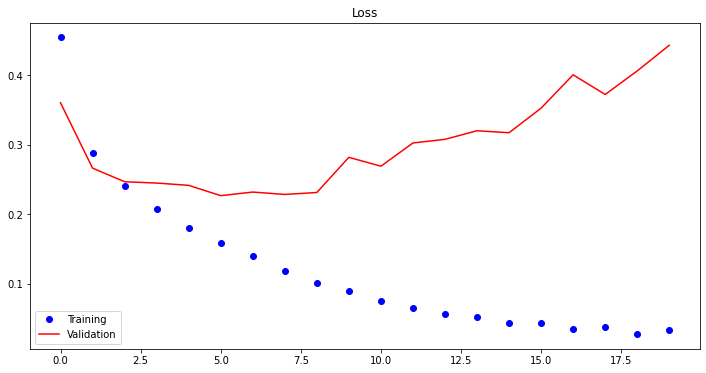

In [17]:
# draw accuracy and loss graphs of the model training metrics 
model_metric(epochs, fashion_train)

After the 5th epoch the model was losing its generalization capability due to the data overfitting. 

To account for the memorizing of the training sequence, the model architecture will modified with a dropout layer. 

Dropout is a regularization technique that randomly drops out a fraction of the input units during training to prevent overfitting and improve generalization.

In [18]:
# defining model architecture

# Define a Sequential model for fashion classification
fashion_model = Sequential()
# Add a convolutional layer with 32 filters of size 3x3 and linear activation 
# function, set input shape to (28,28,1) and padding to 'same'
fashion_model.add(Conv2D(32, kernel_size=(3,3), activation='linear',
                         input_shape=(28,28,1), padding='same'))
# Add a leaky ReLU activation function with alpha=0.1
fashion_model.add(LeakyReLU(alpha=0.1))
# Add a max pooling layer with pool size 2x2 and padding 'same'
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
# Add another convolutional layer with 64 filters of size 3x3 and linear 
# activation function, set padding to 'same'
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
# Add another leaky ReLU activation function with alpha=0.1
fashion_model.add(LeakyReLU(alpha=0.1))
# Add another max pooling layer with pool size 2x2 and padding 'same'
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add another convolutional layer with 128 filters of size 3x3 and linear 
# activation function, set padding to 'same'
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# Add another leaky ReLU activation function with alpha=0.1
fashion_model.add(LeakyReLU(alpha=0.1))
# Add another max pooling layer with pool size 2x2 and padding 'same'
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Flatten the output of the previous layer
fashion_model.add(Flatten())
# Add a fully connected layer with 128 units and linear activation function
fashion_model.add(Dense(128, activation='linear'))
# Add another leaky ReLU activation function with alpha=0.1
fashion_model.add(LeakyReLU(alpha=0.1))
# Add a dropout layer with a rate of 0.3 
fashion_model.add(Dropout(0.3))
# Add a fully connected layer with 10 units and softmax activation function
fashion_model.add(Dense(nClasses, activation='softmax'))

fashion_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

The 14th layer was added to the previously described 13 layers of the model architecture. The model input and output remain the same.

In [19]:
# compiling the modified fashion model in the same setting
fashion_model.compile(loss=keras.losses.categorical_crossentropy, 
                      optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
# training the modified model in the same setting
fashion_train_dropout = fashion_model.fit(train_X, train_label, batch_size=batch_size,
                                  epochs=epochs, verbose=1,
                                  validation_data=(valid_X, valid_label))
# saving the trained model
fashion_model.save("/content/gdrive/MyDrive/stat_ml/fashion_model_dropout.h5py")

Epoch 1/20
750/750 [==============================] - 128s 170ms/step - loss: 0.4901 - accuracy: 0.8221 - val_loss: 0.3177 - val_accuracy: 0.8857
Epoch 2/20
750/750 [==============================] - 112s 149ms/step - loss: 0.2965 - accuracy: 0.8920 - val_loss: 0.2693 - val_accuracy: 0.8996
Epoch 3/20
750/750 [==============================] - 112s 149ms/step - loss: 0.2473 - accuracy: 0.9089 - val_loss: 0.2460 - val_accuracy: 0.9099
Epoch 4/20
750/750 [==============================] - 117s 156ms/step - loss: 0.2178 - accuracy: 0.9195 - val_loss: 0.2285 - val_accuracy: 0.9157
Epoch 5/20
750/750 [==============================] - 106s 141ms/step - loss: 0.1939 - accuracy: 0.9282 - val_loss: 0.2310 - val_accuracy: 0.9140
Epoch 6/20
750/750 [==============================] - 116s 155ms/step - loss: 0.1737 - accuracy: 0.9346 - val_loss: 0.2443 - val_accuracy: 0.9096
Epoch 7/20
750/750 [==============================] - 101s 135ms/step - loss: 0.1557 - accuracy: 0.9407 - val_loss: 0.2258 -

In [20]:
# evaluating the modified model on the previously unseen test dataset
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)
print(f'Test loss:\t{test_eval[0]}')
print(f'Test accuracy:\t{round(test_eval[1] * 100, 2)}%')

Test loss:	0.45766299962997437
Test accuracy:	91.14%


Minor improvements of accuracy and loss in comparison to the previous model.

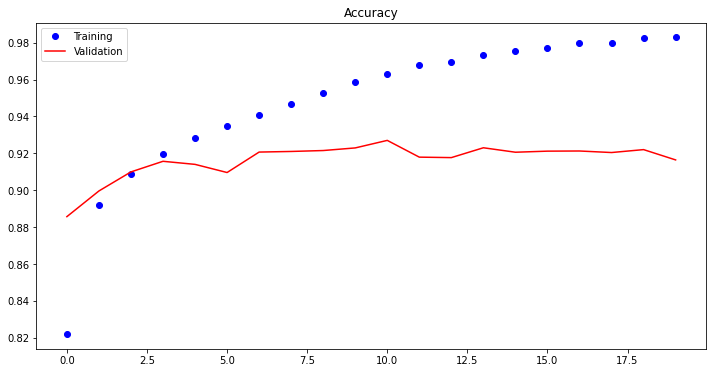

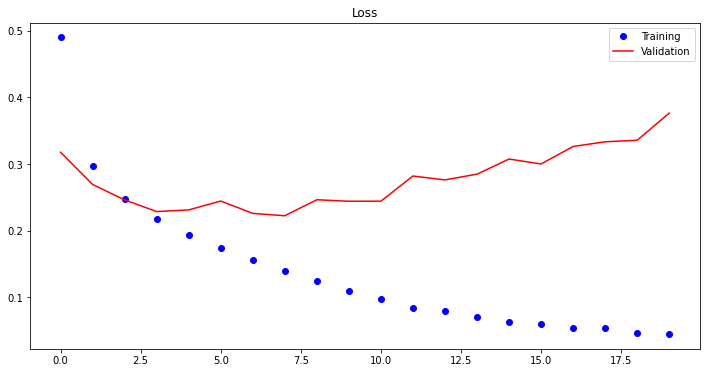

In [21]:
# draw accuracy and loss graphs of the modified model training metrics 
model_metric(epochs, fashion_train_dropout)

The additional dropout layer lowered final values of the validation loss.

In [22]:
# predicting one-hot encoding vectors of the class labels for the test dataset 
# image inputs using the trained model
predicted_classes = fashion_model.predict(test_X)
# converting predicted vector encodings to the initial class label indexes
predicted_classes = np.argmax(np.round(predicted_classes), axis=1)
predicted_classes.shape, test_Y.shape

313/313 [==============================] - 6s 18ms/step


((10000,), (10000,))

In [30]:
# getting indexes of correct predictions in the test dataset
correct = np.where(predicted_classes == test_Y)[0]
print(f"Found {len(correct)} correct labels")

# getting indexes of incorrect predictions in the test dataset
incorrect = np.where(predicted_classes != test_Y)[0]
print(f"Found {len(incorrect)} incorrect labels")

Found 9115 correct labels
Found 885 incorrect labels


In general, the trained model predictions accuracy is quite high.

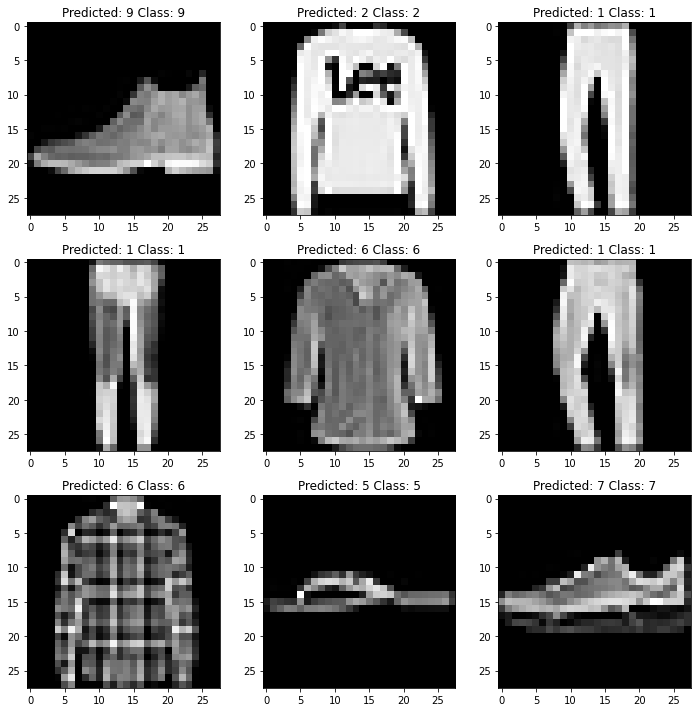

In [27]:
# demonstrating 9 correct predictions
plt.figure(figsize=(10, 10))
for i, correct in enumerate(correct[:9]):
  plt.subplot(3,3,i+1)
  plt.imshow(test_X[correct].reshape(28,28), cmap='gray', interpolation='none')
  plt.title(f"Predicted: {predicted_classes[correct]} Class: {test_Y[correct]}")
plt.tight_layout()
plt.show()

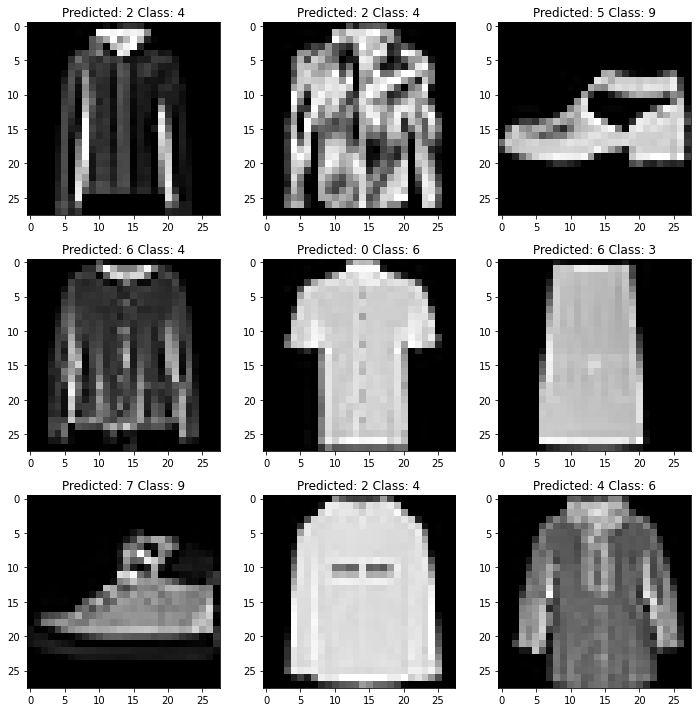

In [32]:
# demonstrating 9 incorrect predictions
plt.figure(figsize=(10, 10))
for i, incorrect in enumerate(incorrect[:9]):
  plt.subplot(3,3,i+1)
  plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
  plt.title(f"Predicted: {predicted_classes[incorrect]} Class: {test_Y[incorrect]}")
plt.tight_layout()
plt.show()

In [34]:
# forming a list of class namings for the classification report
target_names = [f"Class {i+1}" for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 1       0.84      0.89      0.86      1000
     Class 2       0.99      0.98      0.99      1000
     Class 3       0.79      0.92      0.85      1000
     Class 4       0.94      0.90      0.92      1000
     Class 5       0.86      0.84      0.85      1000
     Class 6       0.98      0.98      0.98      1000
     Class 7       0.83      0.69      0.76      1000
     Class 8       0.93      0.98      0.96      1000
     Class 9       0.99      0.98      0.98      1000
    Class 10       0.98      0.94      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In machine learning, precision, recall, and F1 score are metrics used to evaluate the performance of a classification model.

* **Precision**: It is the ratio of true positive samples to the total predicted positive samples. It measures the accuracy of positive predictions. It is calculated as:
Precision = TP / (TP + FP)
where TP (True Positive) is the number of correctly predicted positive samples, and FP (False Positive) is the number of incorrectly predicted positive samples.

* **Recall**: It is the ratio of true positive samples to the total actual positive samples. It measures the ability of the model to find all the positive samples. It is calculated as:
Recall = TP / (TP + FN)
where FN (False Negative) is the number of positive samples that are incorrectly classified as negative.

* **F1 score**: It is the harmonic mean of precision and recall. It gives a balanced measure of precision and recall. It is calculated as:
F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

The classification_report function in scikit-learn computes these metrics for each class in a classification problem and returns a report. The report contains the precision, recall, and F1 score for each class, along with other metrics like support (number of samples in each class) and accuracy.

**According to the generated report, the most difficult to classify labels are 7th (shirts), 3rd (jackets), and 1st (t-shirts). While the easiest to classify labels are 2nd (dress), 9th (sneakers), and 6th (low shoes).**

The main components of a basic artificial neuron are:

* **Input**: The input represents the independent variables or features of the dataset.
* **Weights**: Each input has a weight associated with it, which determines the importance of that input.
* **Bias**: The bias is a constant value that is added to the weighted sum of inputs. It provides an additional degree of freedom to the model.
* **Activation function**: The activation function is applied to the weighted sum of inputs and bias to introduce non-linearity into the output. It determines whether the neuron will be activated or not.

The input values are multiplied by their corresponding weights and then summed up. The bias is then added to this sum. The activation function is applied to this sum to generate the output of the neuron. This output is then passed to the next layer of the neural network as input.

The **summarization block** in a neural network is used to summarize the information from the previous layers into a compressed representation, which can then be used for making final predictions.

There are several functions that can be used in the summarization block, depending on the specific architecture of the network. Some common functions include:

* **Global Average Pooling**: This function takes the average of all the activation values in each feature map of the previous layer, resulting in a single value for each feature map. The resulting values are then concatenated to form a compressed representation of the previous layer.

* **Global Max Pooling**: This function takes the maximum value of each feature map in the previous layer, resulting in a single value for each feature map. The resulting values are then concatenated to form a compressed representation of the previous layer.

* **Flatten**: This function flattens the feature maps of the previous layer into a single vector, which can then be passed through a fully connected layer for final predictions.

* **Attention Mechanisms**: Attention mechanisms can be used to weight the importance of different parts of the previous layer based on their relevance to the final prediction. This can help the network focus on the most important information and improve its accuracy.

Overall, the summarization block plays an important role in reducing the dimensionality of the input data and summarizing the most relevant features for making accurate predictions.

**Deep learning** is a subset of machine learning that involves building and training artificial neural networks with many layers of interconnected nodes, called neurons. These networks are designed to automatically learn from large amounts of data, using a hierarchical and compositional representation of the input.

Deep learning has achieved remarkable success in many areas due to its ability to learn complex, nonlinear patterns and relationships from raw data, without the need for explicit feature engineering.

Deep learning models typically consist of an input layer, multiple hidden layers, and an output layer. Each layer consists of a set of neurons that are connected to the neurons in the previous layer. During training, the weights and biases of the neurons are adjusted to minimize a loss function that measures the difference between the predicted output and the true output.

Deep learning architectures can be classified into two main categories: feedforward neural networks and recurrent neural networks. 

* **Feedforward networks** process the input data sequentially through the layers.
* **Recurrent networks** have feedback connections that allow them to process sequential or time-series data.

CNN stands for **Convolutional Neural Network**. It is a type of artificial neural network that is primarily used for image classification, object detection, and recognition tasks. The architecture of a CNN is designed to process images and other types of multidimensional data, by using a series of convolutional and pooling layers.

CNNs have been used in a variety of research studies across several fields, some of which are:

* **Medical imaging analysis**: CNNs have been used for detecting and diagnosing different diseases such as cancer, Alzheimer's disease, diabetic retinopathy, and more.

* **Natural Language Processing** (NLP): CNNs have been used in text classification, sentiment analysis, and language translation tasks.

* **Autonomous vehicles**: CNNs have been used in the development of self-driving cars, including object detection, tracking, and recognition.

* **Robotics**: CNNs have been used in robotics for object detection, recognition, and grasping.

* **Environmental monitoring**: CNNs have been used for monitoring and predicting natural phenomena such as weather patterns and climate change.

* **Security and surveillance**: CNNs have been used in facial recognition, crowd surveillance, and anomaly detection.

* **Entertainment**: CNNs have been used in the film and gaming industry for generating visual effects and animations.

The **architecture of a CNN** consists of several layers that are stacked on top of each other to extract high-level features from raw input data. The main layers of a CNN are:

* **Input layer**: The input layer takes the raw data as input, such as images or text.

* **Convolutional layer**: The convolutional layer applies a set of learnable filters to the input data to extract features from it. The filters slide over the input data and produce a feature map.

* **Activation layer**: The activation layer applies an activation function to the output of the convolutional layer to introduce non-linearity into the model.

* **Pooling layer**: The pooling layer reduces the dimensionality of the feature map by downsampling it. It helps to extract the most relevant features from the feature map and reduce computation time.

* **Fully connected layer**: The fully connected layer takes the output of the pooling layer and applies a set of weights to produce a class score.

* **Output layer**: The output layer produces the final output of the CNN, which is usually a probability distribution over the output classes.

This architecture is often repeated several times, with multiple convolutional layers, activation layers, pooling layers, and fully connected layers stacked on top of each other. The weights in each layer are learned through backpropagation during training to minimize the error between the predicted output and the actual output.

In terms of CNN, **Convolution** is a process of applying a filter or kernel to an input image or data to extract some features from it. During this process, the filter slides over the entire input image or data and performs element-wise multiplication between its values and the corresponding values in the input image or data. Then it adds the multiplication results and produces a single value in the output feature map. This process helps in extracting the essential features from the input data and preserves the spatial relationship between them.

**Parameters of a CNN**:

* **Filters/Kernels**: The filters/kernels are the learned parameters of a CNN. They are the small matrices that convolve with the input data to extract features.

* **Bias**: Each filter/kernel has a bias term associated with it. It is added to the output of the filter/kernel.

**Hyperparameters of a CNN**:

* **Stride**: It is the number of pixels that the filter/kernel moves during each convolution operation.

* **Padding**: It is the process of adding extra pixels around the edges of the input data before convolution to retain the spatial dimensions of the input.

* **Pooling**: It is the process of downsampling the output of a convolutional layer to reduce its dimensionality.

* **Activation Function**: It is applied to the output of a convolutional layer to introduce non-linearity.

* **Learning Rate**: It determines the step size at which the optimizer adjusts the weights of the model during training.

* **Number of Filters**: It is the number of filters/kernels that are used in a convolutional layer.

* **Kernel Size**: It is the size of the filter/kernel that convolves with the input data.

* **Dropout Rate**: It is the fraction of randomly selected neurons that are dropped out during training to avoid overfitting.

* **Batch Size**: It is the number of input samples that are processed together in one forward/backward pass.

* **Number of Epochs**: It is the number of times the entire training dataset is passed through the network during training.

Some common **activation functions** used in deep learning are:

* Sigmoid function
* ReLU (Rectified Linear Unit) function
* Leaky ReLU function
* Tanh (Hyperbolic tangent) function
* Softmax function
* Swish function
* ELU (Exponential Linear Units) function
* Linear function

**Max pooling** is a technique in CNNs used to reduce the dimensionality of the feature maps. It is applied after convolutional layers and the output of the pooling layer is passed as input to the next convolutional layer. The max pooling operation is performed by sliding a window of size (usually 2x2) over the input feature map and taking the maximum value within each window as the output of the pooling operation.

Max pooling helps in reducing the size of the feature maps, which in turn reduces the number of parameters in the model, making it more efficient to train. It also helps in creating translation invariance in the feature maps, which means that the model can identify the same features irrespective of their position in the input image.

The **training of a CNN** involves the following steps:

1. **Initialization**: The weights and biases of the network are initialized randomly.

2. **Forward propagation**: The input data is fed into the network, and the output is computed using the current weights and biases. This is done by passing the input through the layers of the network and applying the activation function.

3. **Cost computation**: The difference between the predicted output and the actual output (known as the cost or loss function) is computed. This measures the error of the current network.

4. **Backward propagation**: The error is propagated backwards through the layers of the network to compute the gradients of the weights and biases with respect to the cost function.

5. **Parameter update**: The gradients are used to update the weights and biases of the network. This is done using an optimization algorithm such as stochastic gradient descent.

6. **Repeat**: Steps 2-5 are repeated for a number of epochs, until the network's performance on the training data has converged to a satisfactory level.

During the training process, the network learns to optimize its weights and biases to minimize the cost function and improve its accuracy in making predictions.

The backpropagation algorithm and the gradient descent method are used in training neural networks, including deep learning models like CNNs.

**The backpropagation algorithm** is a supervised learning algorithm that is used to train neural networks to minimize the difference between the predicted output and the actual output. During the training phase, the algorithm adjusts the weights of the neurons by propagating the error from the output layer back through the layers of the network, and updating the weights based on the gradient of the loss function with respect to the weights. This allows the network to learn from its mistakes and improve its predictions over time.

**Gradient descent** is an optimization algorithm that is used to minimize the loss function during the training phase. It works by iteratively adjusting the model parameters, such as the weights and biases of the neurons, in the direction of the negative gradient of the loss function with respect to the parameters. By doing so, the algorithm gradually converges to the optimal set of parameters that minimize the loss function and improve the accuracy of the model predictions.

**Overfitting** is a common problem in machine learning, where a model is trained too well on the training data, to the extent that it starts to memorize the training data instead of generalizing patterns in the data. This leads to a situation where the model performs very well on the training data, but poorly on the unseen data or testing data.

Overfitting occurs when a model is too complex relative to the amount of training data it has, and starts to learn noise in the training data instead of the underlying patterns. This can be caused by various factors such as having too many model parameters, insufficient regularization, or lack of diversity in the training data.

To avoid overfitting, techniques such as regularization (includes dropout), early stopping, and data augmentation can be used. These techniques aim to prevent the model from memorizing the training data and encourage it to generalize well to unseen data.